In [1]:
from desc import set_device
set_device("gpu")

/home/fcastro/DESC/desc/__init__.py:99: UserWarning: No GPU found, falling back to CPU
  warnings.warn(colored("No GPU found, falling back to CPU", "yellow"))


In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
#from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list, Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif, cross, dot

from desc.optimize import lsqtr, lsq_auglag

from desc.magnetic_fields import FourierCurrentPotentialField

import time

import numpy as np
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                            plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

#from find_sour import iso_coords_interp, bn_res, B_sour, K_sour, interp_grid, add_extra_coords, add_extra_periodic
from desc.objectives.find_sour import iso_coords_load, iso_coords_interp

ERROR:2025-08-24 20:14:57,753:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/fcastro/.conda/envs/desc-env/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/fcastro/.conda/envs/desc-env/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/fcastro/.conda/envs/desc-env/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CUDA libraries.


(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

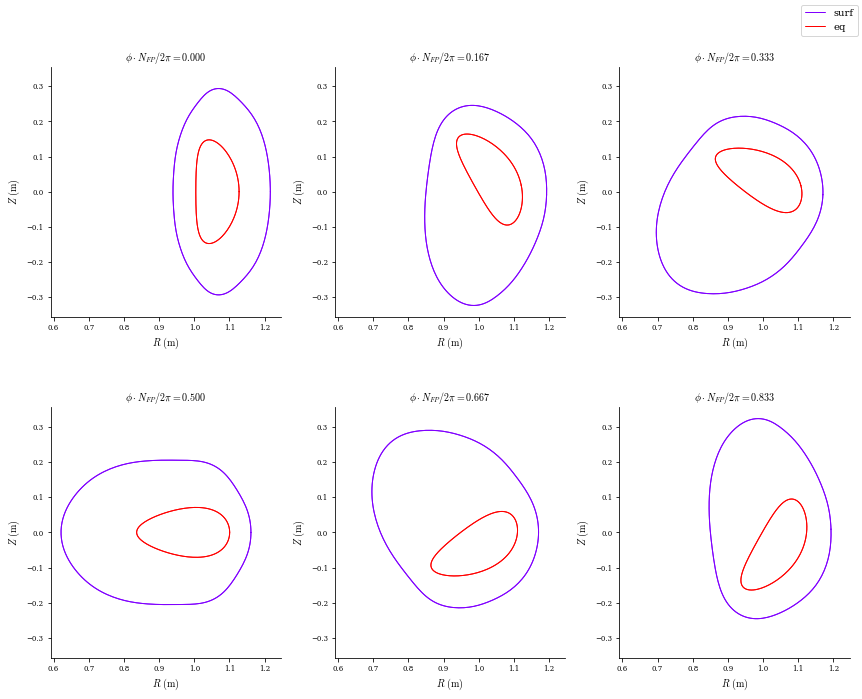

In [3]:
# Plasma surfaces
#eqname_QA = "/scratch/gpfs/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eqname_QA = "input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eq = eq_QA

name = './iso_coords/'
# Winding surfac./e
surf_winding = load(name + "surf.h5")

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

In [4]:
tdata = iso_coords_load(name,surf_winding)

In [5]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 10, N = 10,
                   NFP = surf_winding.NFP,
                  )
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s",'x'], grid = sgrid)
sdata = iso_coords_interp(tdata, sdata, sgrid,)

G = np.load(name + "G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

In [6]:
sgrid2 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*1)).T
                    )
sgrid3 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*2)).T
                    )

sdata2 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s",'x'], grid = sgrid2)
sdata2 = iso_coords_interp(tdata, sdata2, sgrid2)

sdata3 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s",'x'], grid = sgrid3)
sdata3 = iso_coords_interp(tdata, sdata3, sgrid3)

In [7]:
grid_M =10
grid_N =10

In [8]:
egrid = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

In [9]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
sMv = np.asarray([5,]) # Poloidal direction
sNv = np.asarray([5,]) # Toroidal direction

In [10]:
p_M = sMv[0]
p_N = sNv[0]

In [11]:
from desc.magnetic_fields._sinkssources import SinksSources

from desc.objectives import (
    ObjectiveFunction,
    SinksSourcesSurfaceQuadraticFlux,
    SinksSourcesSum,
    SinksSourcesRegularization,
)

In [12]:
sinks_sources_basis = SinksSources(p_M=p_M,p_N=p_N, NFP = surf_winding.NFP)

In [13]:
from desc.objectives.sources_dipoles_utils import alt_grid
#Generate the grid for the controus on the winding surface

theta_coarse = jnp.linspace(
        2 * jnp.pi * (1 / (p_M * 2+1)) * 1 / 2,
        2 * jnp.pi * (1 - 1 / (p_M * 2+1) * 1 / 2),
        p_M * 2+1,
    )

zeta_coarse = jnp.linspace(
            2 * jnp.pi / sinks_sources_basis.NFP * (1 / (p_N * 2+1)) * 1 / 2,
            2 * jnp.pi / sinks_sources_basis.NFP * (1 - 1 / (p_N * 2+1) * 1 / 2),
            p_N * 2+1,
        )

source_grid = alt_grid(theta_coarse, zeta_coarse)

In [14]:
ss_data = surf_winding.compute(["theta", "x",'e^theta_s','e^zeta_s'],grid = source_grid)
ss_data = iso_coords_interp(tdata, ss_data, source_grid,)

In [15]:
#Generate the grid for the controus on the winding surface
# Refine the grid to do the contour integration of the poloidal wires
add_points = 5 # TODO: Make this a control variable in the inputs of this object
from desc.objectives.find_sour import densify_linspace, alt_grid_sticks
theta_contour = densify_linspace(theta_coarse, points_per_interval=add_points)
zeta_contour = zeta_coarse  # no need to refine zeta positions since these are fixed during the integration
    
assert (p_M * 2 + 1) * (p_N * 2 + 1) == theta_coarse.shape[0] * zeta_coarse.shape[0], "Check that the sources coincide with the number of sources/sinks"

r = theta_coarse.shape[0] * zeta_coarse.shape[0]  # ss_data["theta"].shape[0]
    
r_t = theta_coarse.shape[0]
r_z = zeta_coarse.shape[0]
    
contour_grid = alt_grid_sticks(theta_contour, zeta_contour, sgrid)

contour_data = surf_winding.compute(["theta", "x",'e_theta'],grid = contour_grid)
#ss_data = iso_coords_interp(tdata, ss_data, contour_grid,)

In [16]:
# Generate the grid for the sticks

# These are the sticks that are all located at the (theta = pi) cut
theta = jnp.pi * jnp.ones_like(theta_coarse)
stick_grid = alt_grid_sticks(theta, zeta_coarse, sgrid)

stick_data = surf_winding.compute(['theta','x'], grid = stick_grid)

In [17]:
from desc.objectives.find_sour_test import B_sticks, K_sour, B_theta_contours, bn_res

In [18]:
test = B_sticks(p_M,
                p_N,
            sgrid,
            surf_winding,
            jnp.ones((p_M * 2 + 1) * (p_N * 2 + 1) ),
            eq.compute(['x'],grid = egrid)['x'],
            ss_data,)

In [19]:
test.shape

(441, 3)

In [20]:
d_0 = 1e-1

In [21]:
omega_sour_fun = K_sour(p_M,
    p_N,
    sdata,
    sdata,
    sdata,
    sgrid,
    surf_winding,
                   jnp.ones((p_M * 2 + 1) * (p_N * 2 + 1) ),
    N,
    d_0,
    tdata,
    ss_data,)

In [22]:
y = jnp.arange(1,122,1)
coords = eq.compute(['x'],grid = egrid)['x']

In [23]:
test = bn_res(p_M,
    p_N,
    sdata,
    sdata2,
    sdata3,
    sgrid,
    surf_winding,
    y,
    N,
    d_0,
    coords,
    tdata,
    contour_data,
    stick_data,
    contour_grid,
    ss_data,)

In [29]:
test

Array([[ 0.00173147,  0.0248827 , -0.01919426],
       [ 0.00127267,  0.01807371, -0.00063451],
       [ 0.0012578 ,  0.01413642,  0.00274856],
       ...,
       [ 0.00218722,  0.00613763, -0.00775916],
       [ 0.00190423,  0.00580431, -0.00879494],
       [ 0.00154019,  0.00476634, -0.00963267]], dtype=float64)

In [24]:
test.shape

(441, 3)

In [25]:
edata['e_theta'].shape

(441, 3)

In [26]:
omega_sour_fun.shape

(441, 3)

In [27]:
sdata['e_u'].shape

(441, 3)

In [28]:
jnp.sum( ((-jnp.imag(omega_sour_fun)[:, None, :] * sdata['e_v'][:, :, None] 
 + jnp.imag(omega_sour_fun)[:, None, :] * sdata['e_u'][:, :, None]) * y[None,:]) , axis = 2).shape

ValueError: Incompatible shapes for broadcasting: shapes=[(441, 3, 3), (1, 121)]

In [ ]:
y

In [ ]:
sdata['e_u'].shape

In [ ]:
jnp.sum(((omega_sour_fun[:, None, :] * sdata['e_u'][None, :, :].transpose(0, 2, 1)) * y[None,:]), axis = 2).shape

In [ ]:
test.shape

In [ ]:
y.shape

In [ ]:
test = B_theta_contours_test(p_M,
                            p_N,
                            sdata,
                            sgrid,
                            surf_winding,
                            jnp.ones((p_M * 2 + 1) * (p_N * 2 + 1) ),
                            eq.compute(['x'],grid = egrid)['x'],
                            ss_data,
                            contour_grid,)

In [ ]:
test0 = jnp.where( ((contour_data["theta"][:,None] >= theta_coarse[None,]) & (contour_data["zeta"][:,None] == zeta_coarse[None,0])),
                1,0)

test = test0

for i in range(1,p_N*2+1):

    add = jnp.where( ((contour_data["theta"][:,None] >= theta_coarse[None,]) & (contour_data["zeta"][:,None] == zeta_coarse[None,i])),
                1,0)
    test = jnp.column_stack((test,add))

In [ ]:
ss_data = contour_data.copy()

In [ ]:
sign_vals = jnp.where(contour_data["theta"] < jnp.pi, -1, 0) + jnp.where(
        contour_data["theta"] > jnp.pi, 1, 0
    )

In [ ]:
y = jnp.arange(1,122,1)

In [ ]:
A = test
AA = A[:, None, :] * ss_data['e_theta'][:, :, None]
AAA = AA * ( dot(ss_data["e_theta"], ss_data["e_theta"] ) ** (-1 / 2) * sign_vals )[:, None, None]
K_cont = jnp.sum(y[None, None,:]*AAA,axis = 2)
#test3 = test[:,None] * contour_data['x'][:,:,None]

In [ ]:
AAA.shape

In [ ]:
jnp.sum(y[None, None,:]*AAA,axis = 2).shape